### Metrics calculation and some plots
Use this notebook to calculate the BWT and FWT scores for the images the network. This works for the registration predictions as well as U-Net predictions. Just set the paths to the networks predictions correctly and the notebook will do the rest.

#### Set paths

In [1]:
transunet_seq = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/TransUNet_Seq'
transunet_ewc = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/TransUNet_EWC'
# transunet_reh = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/TransUNet_Reh'
transunet_rwalk = '/media/aranem_locale/AR_subs_exps/WACV_2025_NCAdapt/WACV_2025_trained_models_Hip/Experiments/TransUNet_RWalk'

#### Import necessary libraries

In [2]:
from math import pi
import numpy as np
import pandas as pd
import seaborn as sns
from time import sleep
import SimpleITK as sitk
import matplotlib.pyplot as plt
from torch.autograd import Variable
import os, copy, monai, torch
from tqdm.notebook import trange, tqdm

#### Helpful functions and other stuffs

In [3]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])
    
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

### TransUNet results

In [4]:
models = [x for x in os.listdir(transunet_seq) if 'transunet' in x.lower()]

models.sort()
dices_s = dict()
for model in models:
    dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(transunet_seq, model)) if 'inference' in x]

    for pred in preds_:
        preds = os.path.join(transunet_seq, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_s[model.replace('_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_Seq/TransUNet_Hyp97_None/inference..
Dice for model TransUNet_Hyp97_None:


Task97_DecathHip: Mean dice +/- std: 90.49 (2.34)
Task98_Dryad: Mean dice +/- std: 57.92 (14.72)
Task99_HarP: Mean dice +/- std: 65.19 (18.98)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_Seq/TransUNet_Hyp98_None/inference..
Dice for model TransUNet_Hyp98_None:
Task97_DecathHip: Mean dice +/- std: 56.92 (15.83)
Task98_Dryad: Mean dice +/- std: 89.26 (1.2)
Task99_HarP: Mean dice +/- std: 41.86 (24.65)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_Seq/TransUNet_Hyp99_98_97_None/inference..
Dice for model TransUNet_Hyp99_98_97_None:
Task97_DecathHip: Mean dice +/- std: 91.63 (2.46)
Task98_Dryad: Mean dice +/- std: 84.61 (2.02)
Task99_HarP: Mean dice +/- std: 78.25 (9.48)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_Seq/TransUNet_Hyp99_98_None/inference..
Dice for model TransUNet_Hyp99_98_None:
T

In [ ]:
# Rehearsal
models = [x for x in os.listdir(transunet_reh)  if 'transunet' in x.lower()]

models.sort()
dices_reh = dict()
for model in models:
    dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(transunet_reh, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(transunet_reh, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_reh[model.replace('_reh_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

In [5]:
# EWC
models = [x for x in os.listdir(transunet_ewc)  if 'transunet' in x.lower()]

models.sort()
dices_ewc = dict()
for model in models:
    dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(transunet_ewc, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(transunet_ewc, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_ewc[model.replace('_ewc_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_EWC/TransUNet_Hyp97_ewc_None/inference..
Dice for model TransUNet_Hyp97_ewc_None:


Task97_DecathHip: Mean dice +/- std: 90.49 (2.34)
Task98_Dryad: Mean dice +/- std: 57.92 (14.72)
Task99_HarP: Mean dice +/- std: 65.19 (18.98)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_EWC/TransUNet_Hyp98_ewc_None/inference..
Dice for model TransUNet_Hyp98_ewc_None:
Task97_DecathHip: Mean dice +/- std: 56.92 (15.83)
Task98_Dryad: Mean dice +/- std: 89.26 (1.2)
Task99_HarP: Mean dice +/- std: 41.86 (24.65)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_EWC/TransUNet_Hyp99_98_97_ewc_None/inference..
Dice for model TransUNet_Hyp99_98_97_ewc_None:
Task97_DecathHip: Mean dice +/- std: 91.97 (2.37)
Task98_Dryad: Mean dice +/- std: 85.54 (1.76)
Task99_HarP: Mean dice +/- std: 76.63 (10.3)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_EWC/TransUNet_Hyp99_98_ewc_None/inference..
Dice for model TransU

In [6]:
# RWalk
models = [x for x in os.listdir(transunet_rwalk)  if 'transunet' in x.lower()]

models.sort()
dices_rwalk = dict()
for model in models:
    dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')] = dict()
    preds_ = [x for x in os.listdir(os.path.join(transunet_rwalk, model)) if 'inference' in x]
    for pred in preds_:
        preds = os.path.join(transunet_rwalk, model, pred)
        print(f"Looking in {preds}..")
        # -- Load the data -- #
        try:
            ds = [x for x in os.listdir(preds) if 'csv' not in x]
            ds.sort()
            print(f'Dice for model {model}:')
        except:
            continue
        
        for datas in ds:
            dices_ = list()
            dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')] = dict()
            cases = [x for x in os.listdir(os.path.join(preds, datas)) if 'DS_' not in x]
            for case in cases:
                dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case] = dict()
                gt = np.int32(sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'seg_gt.nii.gz'))))
                y_p = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(preds, datas, case, 'pred_seg.nii.gz')))
                y_p_t = torch.from_numpy(y_p).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                gt_t = torch.from_numpy(gt).to(0).unsqueeze(0).unsqueeze(0).float()#.permute(0, 4, 1, 2, 3)
                dice = monai.metrics.DiceMetric(include_background=False, ignore_empty=False)(y_p_t, gt_t).cpu().item()
                dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')][case]['pred'] = np.round(dice, 4)
                dices_.append(dice)

            print(f"{datas}: Mean dice +/- std: {trunc(np.round(np.mean(dices_), decimals=4)*100, 2)} ({trunc(np.round(np.std(dices_), decimals=4)*100, 2)})") 
            
            dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_moved'] = np.mean(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_std_moved'] = np.std(dices_)
            dices_rwalk[model.replace('_rwalk_None', '').replace('TransUNet_', '').replace('Hyp', '')][datas.split('_')[0].replace('Task', '')]['mean_dice_std_moved'] = str(np.round(np.mean(dices_), 4)) + '(' + str(np.round(np.std(dices_), 4)) +')'
        print()

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_RWalk/TransUNet_Hyp97_rwalk_None/inference..
Dice for model TransUNet_Hyp97_rwalk_None:


Task97_DecathHip: Mean dice +/- std: 90.49 (2.34)
Task98_Dryad: Mean dice +/- std: 57.92 (14.72)
Task99_HarP: Mean dice +/- std: 65.19 (18.98)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_RWalk/TransUNet_Hyp98_rwalk_None/inference..
Dice for model TransUNet_Hyp98_rwalk_None:
Task97_DecathHip: Mean dice +/- std: 56.92 (15.83)
Task98_Dryad: Mean dice +/- std: 89.26 (1.2)
Task99_HarP: Mean dice +/- std: 41.86 (24.65)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_RWalk/TransUNet_Hyp99_98_97_rwalk_None/inference..
Dice for model TransUNet_Hyp99_98_97_rwalk_None:
Task97_DecathHip: Mean dice +/- std: 91.75 (2.46)
Task98_Dryad: Mean dice +/- std: 84.65 (1.79)
Task99_HarP: Mean dice +/- std: 78.73 (8.14)

Looking in /media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_trained_models_Hip/Experiments/TransUNet_RWalk/TransUNet_Hyp99_98_rwalk_None/inference..
Dice 

In [7]:
data = {'TransUNet': dices_s, 'TransUNet_EWC': dices_ewc, 'TransUNet_RWalk': dices_rwalk, #'TransUNet_Rehearsal': dices_reh
       }

#### Forgetting, Positive Backward Transfer, Remembering and Forward Transfer

In [8]:
tasks = ['99', '98', '97']
methods = ['TransUNet', 'TransUNet_EWC', 'TransUNet_RWalk']#, 'TransUNet_Rehearsal']
B_T, F_T, F_NEG, F_POS, B_TP, FOR, REM, Dice, Dice_F, Dice_L, STD = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
Dice_2 = dict()

all_t_j = '_'.join(tasks)
for m in methods:
    B_T[m], F_T[m], F_NEG[m], F_POS[m], B_TP[m], FOR[m], REM[m], Dice[m], Dice_F[m], Dice_L[m], STD[m] = dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict(), dict()
    Dice_2[m] = dict()
    t_list = list()
    for t in tasks:
        t_list.append(t)
        Dice_t_all = (data[m][all_t_j][t]['mean_dice_moved'],
                        data[m][all_t_j][t]['mean_std_moved'])
        
        Dice_t = (data[m]['_'.join(t_list)][t]['mean_dice_moved'],
                    data[m]['_'.join(t_list)][t]['mean_std_moved'])
        
        if len(t_list) > 1:
            Dice_t_prev = (data[m]['_'.join(t_list[:-1])][t]['mean_dice_moved'],
                            data[m]['_'.join(t_list[:-1])][t]['mean_std_moved'])
            F_T[m][t] = Dice_t_prev[0] - data[m][t][t]['mean_dice_moved']
            F_NEG[m][t] = abs(min(F_T[m][t], 0))
            F_POS[m][t] = 1 - abs(min(F_T[m][t], 0))
        
        if '_'.join(t_list) == all_t_j: # Only add this once
            Dice_F[m][t] = data[m][all_t_j][tasks[0]]['mean_dice_moved']
            Dice_2[m][t] = data[m][all_t_j][tasks[1]]['mean_dice_moved']
            Dice_L[m][t] = data[m][all_t_j][tasks[2]]['mean_dice_moved']
        
        Dice[m][t] = data[m][all_t_j][t]['mean_dice_moved']

        if '_'.join(t_list) != all_t_j:
            B_T[m][t] = Dice_t_all[0] - Dice_t[0]
            B_TP[m][t] = max(B_T[m][t], 0)
            FOR[m][t] = abs(min(B_T[m][t], 0))
            REM[m][t] = 1 - abs(min(B_T[m][t], 0))

In [9]:
print('BWT, FWT [%]')
for m in methods:
    print(m)
    print(np.mean(np.asarray(list(B_T[m].values()))*100), '+\-', np.std(np.asarray(list(B_T[m].values()))*100))
    # print(np.mean(np.asarray(list(REM[m].values()))*100), '+\-', np.std(np.asarray(list(REM[m].values()))*100))
    print(np.mean(np.asarray(list(F_T[m].values()))*100), '+\-', np.std(np.asarray(list(F_T[m].values()))*100))
    # print(np.mean(np.asarray(list(Dice[m].values()))*100), '+\-', np.std(np.asarray(list(Dice[m].values()))*100))

BWT, FWT [%]
TransUNet
-6.153699374548793 +\- 0.7793882982785831
-9.951189397901732 +\- 3.715213708543547
TransUNet_EWC
-6.774962410736884 +\- 2.0839232193848867
-15.32603308630451 +\- 6.9987502866897096
TransUNet_RWalk
-5.569690575264785 +\- 0.31186618082678086
-10.927985407915958 +\- 5.446453522980794


In [11]:
print('Mean Dice [%]')
for m in methods:
    print(m)
    print(np.mean(list(Dice[m].values()))*100)
    print(np.std(list(Dice[m].values()))*100)

Mean Dice [%]
TransUNet
84.82919792718165
5.464306695402738
TransUNet_EWC
84.71621115971614
6.295059024679493
TransUNet_RWalk
85.05040008141336
5.318860324055824


In [13]:
print('Mean Forgetting [%]')
for m in methods:
    print(m)
    print(np.mean(list(FOR[m].values()))*100)

Mean Forgetting [%]
TransUNet
6.153699374548793
TransUNet_EWC
6.774962410736885
TransUNet_RWalk
5.569690575264785


#### Spider Plots

In [14]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'Dice Mean': [np.mean(list(Dice[m].values()))*100 for m in methods],
'100 + BWT': [100 + np.mean(list(B_T[m].values()))*100 for m in methods],
'Dice Last': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
'Dice First': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'100 + FWT': [100 + np.mean(list(F_T[m].values()))*100 for m in methods]
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    # ax.xaxis.set_tick_params(pad=35)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    plt.xticks(angles[:-1], categories, color='black', size=15)
    
    for i, tick in enumerate(ax.get_xaxis().get_major_ticks()):
        if i == 1 or i == 4:
            tick.set_pad(35)
        else:
            tick.set_pad(15)

    # Draw ylabels
    # ax.set_rlabel_position(0)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=9)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

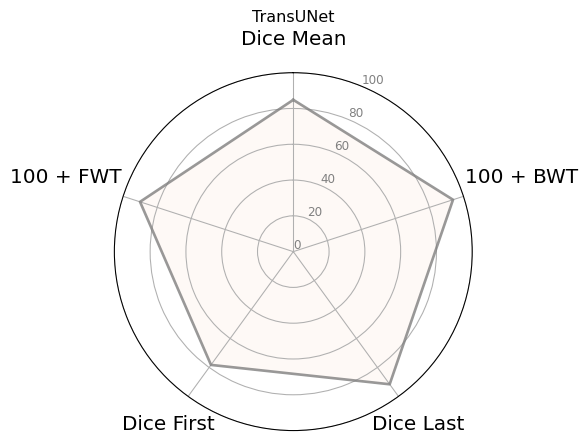

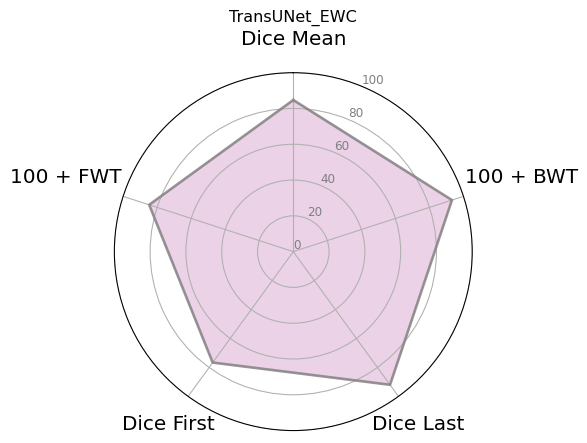

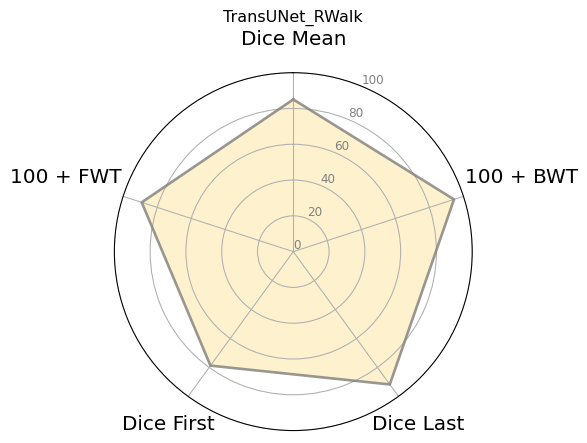

In [15]:
# ------- PART 2: Apply the function to all individuals
colors = {'TransUNet': '#fae5d6', 'TransUNet_RWalk':'#fec10b', 'TransUNet_EWC':'#9e1e83'}#, 'TransUNet_Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_evaluation/plots/hip_spiders_{title}.pdf', bbox_inches='tight')

In [16]:
plt.figure(figsize=(13, 6))

df = pd.DataFrame({
'methods': methods,
'$\mathcal{T}_{1}$': [np.mean(list(Dice_F[m].values()))*100 for m in methods],
'$\mathcal{T}_{2}$': [np.mean(list(Dice_2[m].values()))*100 for m in methods],
'$\mathcal{T}_{3}$': [np.mean(list(Dice_L[m].values()))*100 for m in methods],
}) 
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color, h_=None):

    # number of variable
    categories=list(df)[1:]
    N = len(categories)

    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Initialise the spider plot
    ax = plt.subplot(3, 3, row+1, polar=True)

    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.xaxis.set_tick_params(pad=15)    # Add padding to labels

    # Draw one axe per variable + add labels yet
    # plt.xticks(angles[:-1], categories, color='black', size=15)
    plt.xticks(angles[:-1], categories, color='black', size=31)
    
    # Draw ylabels
    # ax.set_rlabel_position(0)
    # plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=11)
    plt.yticks(range(0, 101, 20), [str(x) for x in range(0, 101, 20)], color="grey", size=15)
    plt.ylim(0,100)

    # Ind1
    values=df.loc[row].drop('methods').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color='grey', alpha=0.8, linewidth=2, linestyle='solid')
    if h_ is not None:
        ax.fill(angles, values, color=color, alpha=h_)
    else:
        ax.fill(angles, values, color=color)
            
    # Add a title
    plt.title(title)

<Figure size 1300x600 with 0 Axes>

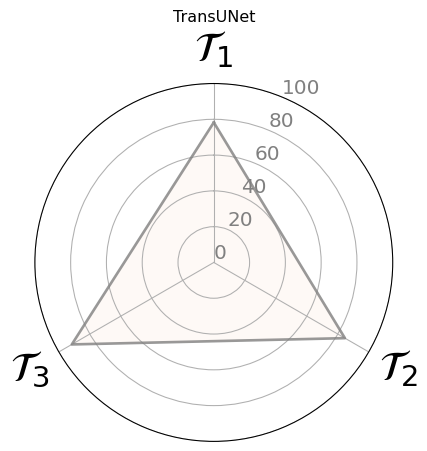

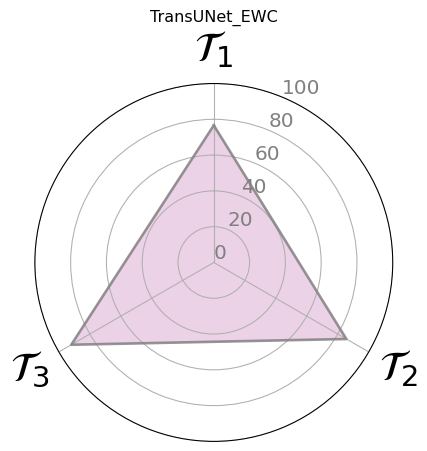

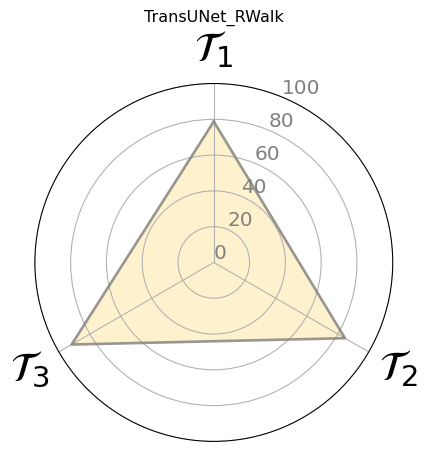

In [17]:
# ------- PART 2: Apply the function to all individuals
colors = {'TransUNet': '#fae5d6', 'TransUNet_RWalk':'#fec10b', 'TransUNet_EWC':'#9e1e83'}#, 'TransUNet_Rehearsal': '#26a671'

# Loop to plot
for row in range(0, len(df.index)):

    # Plot one after the other to save as pdf for better plotting
    my_dpi=96
    plt.figure(figsize=(13, 13), dpi=my_dpi)
    plt.subplots_adjust(right=1.1, top=1.1)
    plt.tight_layout()

    make_spider(row=row, title=df['methods'][row], color=colors[methods[row]], h_=0.2 if methods[row] not in ['U-Net', 'Atlas Replay'] else None)
    # make_spider( row=row, title=df['method'][row], color=my_palette(row))
    title = df['methods'][row]
    plt.savefig(f'/media/aranem_locale/AR_subs_exps/MICCAI_2024/MICCAI_2024_evaluation/plots/hip_spiders_{title}_dices.pdf', bbox_inches='tight')